# Compare CP2K to G4MP2 with Gaussian
G4MP2 with Gaussian is our baseline, and we've validated that it agrees well with experiment for IPs.
Our goal here is to see how well CP2K with different flavors of DFT holds up.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from ase import units
import pandas as pd

## Load in the G4MP2 and CP2K results
They are stored in two different JSON files. 

The G4MP2 is per molecule and it already includes the IE (computed in eV).

In [2]:
g4mp2_data = pd.read_json('./data/g4mp2-mols.json', lines=True)
print(f'Loaded {len(g4mp2_data)} G4MP2 results')

Loaded 3405 G4MP2 results


Load the CP2K, which are stored per-calculation. We'll need to compute IE ourselves

In [3]:
cp2k_raw_data = pd.read_json('output.json', lines=True).drop(columns=['result'])
print(f'Loaded {len(cp2k_raw_data)} calculations of {len(set(cp2k_raw_data.filename))} molecules')

Loaded 14394 calculations of 3026 molecules


In [4]:
cp2k_neutral = cp2k_raw_data.query('charge==0')

In [5]:
cp2k_oxidize = cp2k_raw_data.query('charge==1')

In [6]:
cp2k_data = cp2k_neutral.merge(cp2k_oxidize, on=['config_name', 'filename', 'smiles'], suffixes=['_neutral', '_oxidized'])
cp2k_data['IE'] = cp2k_data['energy_oxidized'] - cp2k_data['energy_neutral']

## Compare to G4MP2
Compare each of configurations we've run with CP2K

In [7]:
total_configs = len(set(cp2k_data.config_name))

cp2k_blyp_dzvp 0.2199642501846128
cp2k_blyp_szv 0.4103611356983977
cp2k_blyp_tzvp 0.22373186911038961


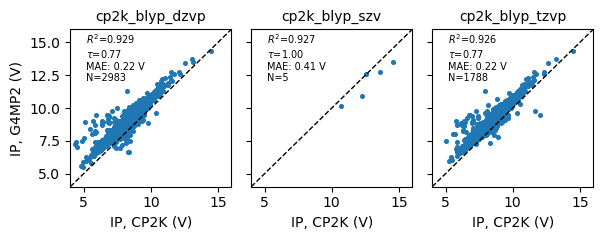

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6, 2.5))

for ax, (gid, group) in zip(axs, cp2k_data.groupby('config_name')):
    ax.set_title(gid, fontsize=10)
    
    # Plot the data
    merged = group.merge(g4mp2_data, on=['filename'])
    r2 = pearsonr(merged['IE'], merged['G4MP2_IP_ASC'])
    tau = kendalltau(merged['IE'], merged['G4MP2_IP_ASC'])
    offset = (merged['IE'] - merged['G4MP2_IP_ASC']).mean()
    mae = ((merged['IE'] - merged['G4MP2_IP_ASC']) - offset).abs().mean()
    print(gid, mae)
    ax.scatter(merged['IE'], merged['G4MP2_IP_ASC'], s=7)
    ax.text(0.1, 0.98, f'$R^2$={r2[0]:.3f}\n$\\tau$={tau[0]:.2f}\nMAE: {mae:.2f} V\nN={len(merged)}', 
           transform=ax.transAxes, va='top', fontsize=7)
    
    # Plot y=x
    ax.set_xlim(4, 16)
    ax.set_ylim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('IP, CP2K (V)')

axs[0].set_ylabel('IP, G4MP2 (V)')
fig.tight_layout()